# Read in data

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np

from utils.condense_hector_output import condense_output
from utils.process_raw_hector_output import process_csv_to_xarray

In [2]:
input_path = "../data/postprocessed-hector/netcdfs/"
DAC_emissionsDriven = xr.open_dataset(input_path + "DAC_emissionsDriven_postprocessed.nc")
DOR_emissionsDriven = xr.open_dataset(input_path + "DOR_emissionsDriven_postprocessed.nc")
emissionsPulse_emissionsDriven = xr.open_dataset(input_path + "emissionsPulse_emissionsDriven_postprocessed.nc")

DOR_concentrationDriven = xr.open_dataset(input_path + "DOR_concentrationDriven_postprocessed.nc")
DOR_concentrationDriven_highWind = xr.open_dataset(
    input_path + "DOR_concentrationDriven_highWind_postprocessed.nc"
)
DOR_concentrationDriven_lowWind = xr.open_dataset(
    input_path + "DOR_concentrationDriven_lowWind_postprocessed.nc"
)

DAC_concentrationDriven = xr.open_dataset(input_path + "DAC_concentrationDriven_synthetic_data.nc")
emission_concentrationDriven = xr.open_dataset(
    input_path + "emission_concentrationDriven_synthetic_data.nc"
)

# Convert data into json with flat structure

In [3]:
datasets = [
    DAC_emissionsDriven,
    DOR_emissionsDriven,
    emissionsPulse_emissionsDriven,
    DAC_concentrationDriven,
    DOR_concentrationDriven,
    emission_concentrationDriven,
    DOR_concentrationDriven_highWind,
    DOR_concentrationDriven_lowWind,
]

perturbation_types = ["DAC", "DOR", "emission", "DAC", "DOR", "emission", "DOR", "DOR"]
carbon_cycle_feedbacks = ["on", "on", "on", "off", "off", "off", "off", "off"]
wind_speed = ["default", "default", "default", "default", "default", "default", "high", "low"]

In [4]:
df_list = []
for i, ds in enumerate(datasets):
    if carbon_cycle_feedbacks[i] == "off":
        var_to_use = "implied_delta_atmos_co2_GtCO2"
    elif carbon_cycle_feedbacks[i] == "on":
        var_to_use = "delta_atmos_co2_GtCO2"

    df = ds[var_to_use].to_dataframe(name="value")

    # Add labels
    df["perturbation_type"] = perturbation_types[i]
    df["carbon_cycle_feedback"] = carbon_cycle_feedbacks[i]
    df["wind_speed"] = wind_speed[i]
    df["variable_label"] = var_to_use
    df["years_after_deployment"] = ds["years_after_deployment"]
    df_list.append(df)

df_all = pd.concat(df_list)
df_all = df_all.reset_index()

In [5]:
df_all_coarsened_time = df_all[
    ((df_all.years_after_deployment <= 100) | (df_all.years_after_deployment % 100 == 0))
]
df_all_coarsened_time = df_all_coarsened_time[df_all_coarsened_time.years_after_deployment > -10]

In [6]:
df_output = df_all_coarsened_time

# Test flat dataset

In [7]:
# Parameters to select
carbon_cycle_feedback = "on"
time_horizon = 10

# Get the right time series using
tseries_to_use_DOR = df_output[
    (df_output.perturbation_type == "DOR")
    & (df_output.carbon_cycle_feedback == carbon_cycle_feedback)
    & (df_output.wind_speed == "default")
]
tseries_to_use_DAC = df_output[
    (df_output.perturbation_type == "DAC")
    & (df_output.carbon_cycle_feedback == carbon_cycle_feedback)
    & (df_output.wind_speed == "default")
]

tseries_to_use_emission = df_output[
    (df_output.perturbation_type == "emission")
    & (df_output.carbon_cycle_feedback == carbon_cycle_feedback)
    & (df_output.wind_speed == "default")
]

(-10.0, 100.0)

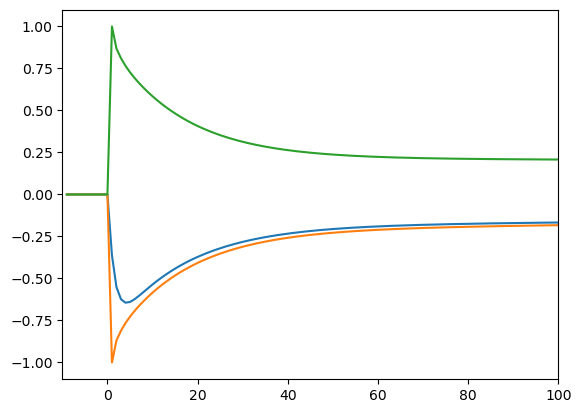

In [8]:
plt.plot(tseries_to_use_DOR.years_after_deployment, tseries_to_use_DOR.value)
plt.plot(tseries_to_use_DAC.years_after_deployment, tseries_to_use_DAC.value)
plt.plot(tseries_to_use_emission.years_after_deployment, tseries_to_use_emission.value)
plt.xlim([-10, 100])

# Save json

In [9]:
json_directory = "../data/postprocessed-hector/jsons_for_article/"
df_output.to_json(json_directory + "DOR_vs_DAC_combined.json", orient="table")